TITLE: CNN Xception Transfer learning model for medical imaging analysis

INTRODUCTION:
Xception is a convolutional neural network that is 71 layers deep.
We can load a pretrained version of the network trained on more than a million images from the ImageNet database.
The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.
As a result, the network has learned rich feature representations for a wide range of images such as the biomedical images.

DATASET DESCRIPTION:
Dataset: (Chest X-ray)- Pneumoniae data set.
Source: htps://data.mendeley.com/datasets/rscbjbr9sj/2
Chest X-ray images (anterior posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
Description: There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

AIM:
In this Project, I aim to develop a pneumoniae diagnosis system using the Xception transfer learning algorithm.
I carried out  some exploratory analysis (Distribution and count of different categories)
I  also performed certain parameter optimizations for  higher accuracy.

OUTCOME:
I obtained a 95% model accuracy
The model accurately predicted a NORMAL sampled image at random


In [ ]:
#Loading required Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading Dataset
BASE_URL = "Desktop/\chestxray"

In [ ]:
#Accessing individual folders in the dataset folder
train = "Desktop/\chestxray/train"
test = "Desktop/\chestxray/test"
val = "Desktop/\chestxray/val"
FOLDERS = ['test', 'val', 'train']
CATEGORIES = ['NORMAL', 'PNEUMONIA']

In [ ]:
#get all the image filenames on normal class and create a dataframe
class_normal = []

for f in FOLDERS:
    folder = os.path.join(BASE_URL, f)

    for path in os.listdir(os.path.join(folder, 'NORMAL')):
        class_normal.append([os.path.join(folder, 'NORMAL/'+path), 0])
normal_df = pd.DataFrame(class_normal, columns=['filepaths', 'labels'])

In [ ]:
#get all the image filenames on pneumonia class and create a dataframe

class_pneumonia = []

for f in FOLDERS:
    folder = os.path.join(BASE_URL, f)

    for path in os.listdir(os.path.join(folder, 'PNEUMONIA')):
        class_pneumonia.append([os.path.join(folder, 'PNEUMONIA/'+path), 1])
pneumonia_df = pd.DataFrame(class_pneumonia, columns=['filepaths', 'labels'])

In [ ]:
#concatenating the two dataframes above
df = pd.concat([normal_df, pneumonia_df], axis=0).reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,filepaths,labels
0,Desktop/\chestxray\test\NORMAL/IM-0001-0001.jpeg,0
1,Desktop/\chestxray\test\NORMAL/IM-0003-0001.jpeg,0
2,Desktop/\chestxray\test\NORMAL/IM-0005-0001.jpeg,0
3,Desktop/\chestxray\test\NORMAL/IM-0006-0001.jpeg,0
4,Desktop/\chestxray\test\NORMAL/IM-0007-0001.jpeg,0


In [ ]:
#show dataframe shape
print('DATAFRAME SHAPE: ',df.shape)
print(df.labels.value_counts())

DATAFRAME SHAPE:  (5856, 2)
labels
1    4273
0    1583
Name: count, dtype: int64


In [ ]:
#defines a function to load images and convert them to python arrays
def read_img(path, target_size):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img) /255.
    return img

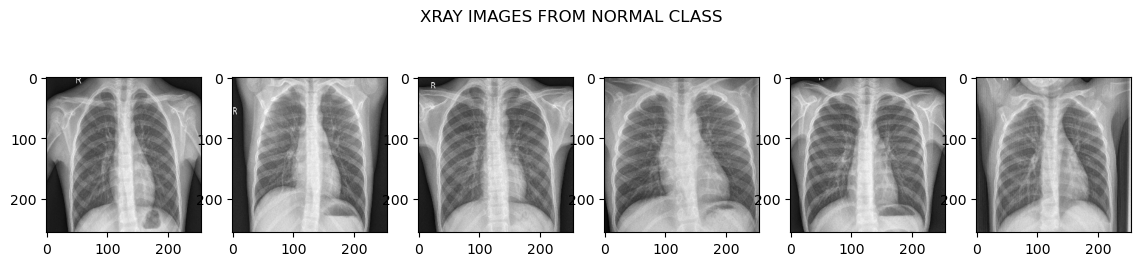

In [ ]:
#show sample image from normal_class

fig, ax = plt.subplots(1,6,figsize=(14,3));
plt.suptitle('XRAY IMAGES FROM NORMAL CLASS')

for i,path in enumerate(normal_df.filepaths[:6].values):
    ax[i].imshow(read_img(path, (255,255)))

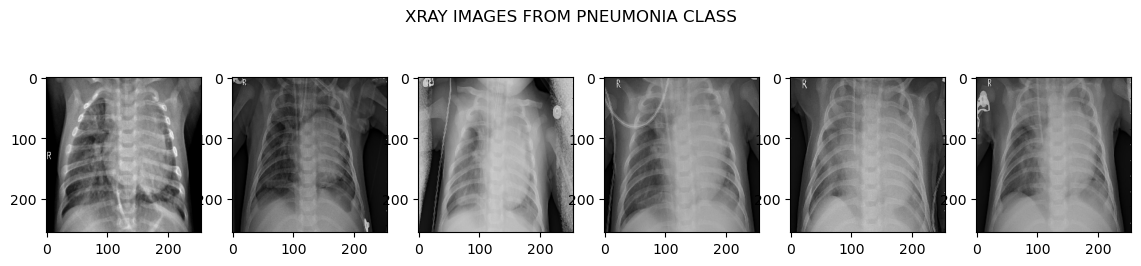

In [ ]:
#show sample image from pneumonia_class

fig, ax = plt.subplots(1,6,figsize=(14,3));
plt.suptitle('XRAY IMAGES FROM PNEUMONIA CLASS')

for i,path in enumerate(pneumonia_df.filepaths[:6].values):
    ax[i].imshow(read_img(path, (255,255)))

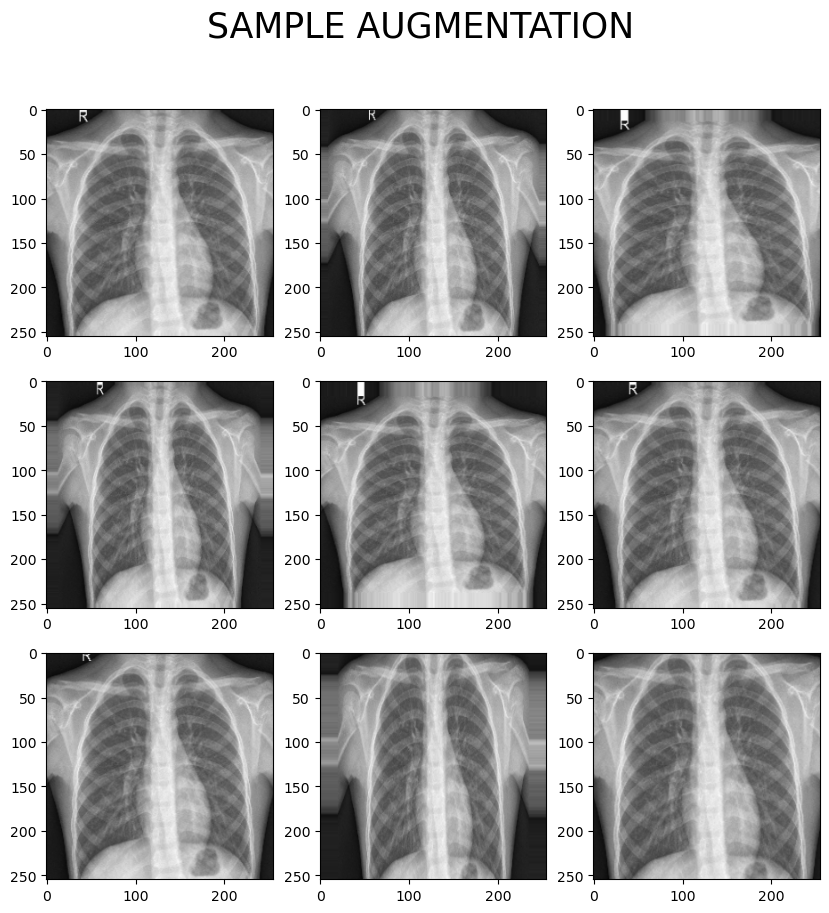

In [ ]:
#Image augmentation for Pneumonia chestxray images
#create a imagegenerator
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2
)

#load a sample image
sample_image = (read_img(normal_df.filepaths[0], (255,255)))

#This section of the code loads an image from the normal images folder and augments it showing slightly different details in theimage according to the shear and zoom range parameter that was initialized with the image generator.
#  visualization can help us understand the variations in the images that the neural network will see during training.

plt.figure(figsize=(10,10))
plt.suptitle('SAMPLE AUGMENTATION', fontsize=25)

i = 0
#generate and show
for batch in datagen.flow(tf.expand_dims(sample_image,0), batch_size=32):
    plt.subplot(3,3, i+1)
    plt.grid(False)
    plt.imshow(tf.squeeze(batch, 0));

    if i == 8:
        break
    i = i+1
plt.show();

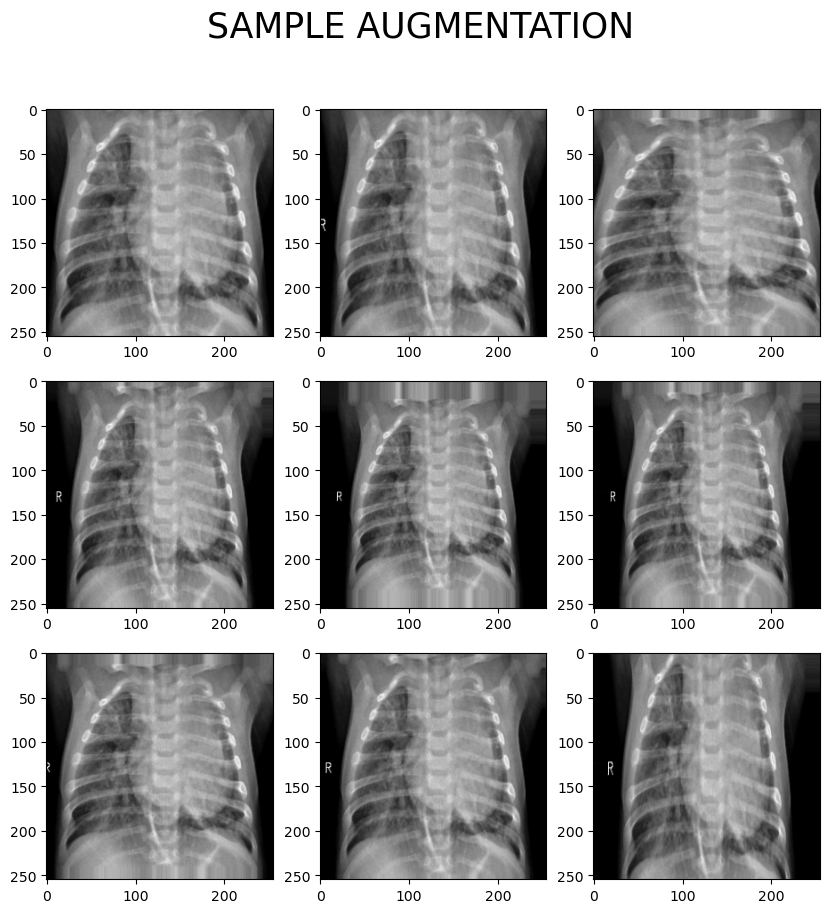

In [ ]:
#Image augmentation for Pneumonia chestxray images
#create a imagegenerator
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2
)

#load a sample image
sample_image = (read_img(pneumonia_df.filepaths[0], (255,255)))

plt.figure(figsize=(10,10))
plt.suptitle('SAMPLE AUGMENTATION', fontsize=25)

i = 0
#generate and show
for batch in datagen.flow(tf.expand_dims(sample_image,0), batch_size=32):
    plt.subplot(3,3, i+1)
    plt.grid(False)
    plt.imshow(tf.squeeze(batch, 0));

    if i == 8:
        break
    i = i+1
plt.show();

In [ ]:
#This code defines a function to collects all 'normal' augmented image, to create a dataset for training the model.
augmented_img = []

#function for augmentation
def augment(path):
#load images then transform
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (150,150))
    i=0
    for batch in datagen.flow(tf.expand_dims(img, 0), batch_size=32):
        augmented_img.append(tf.squeeze(batch, 0))

        if i == 2:
            break
        i = i+1
#apply the augmentation function
normal_df['filepaths'].apply(augment)


0       None
1       None
2       None
3       None
4       None
        ... 
1578    None
1579    None
1580    None
1581    None
1582    None
Name: filepaths, Length: 1583, dtype: object

In [ ]:
#convert the augmented 'normal' images as tensors
normal_tensor =  tf.convert_to_tensor(augmented_img)
normal_tensor.shape

TensorShape([4749, 150, 150, 3])

In [ ]:
#This code defines a function to collects all 'pneumoniae' images to create a dataset for training the model
#same function but without augmentation
pneumonia_tensor = []
IMAGE_SIZE = 150
def map_fn(path):
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    pneumonia_tensor.append(img)
pneumonia_df.filepaths.apply(map_fn)

0       None
1       None
2       None
3       None
4       None
        ... 
4268    None
4269    None
4270    None
4271    None
4272    None
Name: filepaths, Length: 4273, dtype: object

In [ ]:
#convert pneumonia images to tensor
pneumonia_tensor = tf.convert_to_tensor(pneumonia_tensor)
pneumonia_tensor.shape

TensorShape([4273, 150, 150, 3])

In [ ]:
#generate labels for the generated tensor dataset
normal_labels = tf.zeros(len(normal_tensor), dtype = np.int64)
pneumonia_labels = tf.ones(len(pneumonia_tensor), dtype=np.int64)

In [ ]:
#concanating normal and pneumonia tensor dataset
tensor_dataset = tf.data.Dataset.from_tensor_slices( (tf.concat([normal_tensor, pneumonia_tensor], axis=0),
                                                      tf.concat([normal_labels, pneumonia_labels], axis=0)))

In [ ]:
#This code defines a function to split the newly generated tensor dataset into test and train dataset
# TRAIN_SIZE = int(len(tensor_dataset) *0.7)
#BUFFER_SIZE = 101
#tensor_dataset = tensor_dataset.shuffle(BUFFER_SIZE)
# train_data = tensor_dataset.take(TRAIN_SIZE)
# test_data = tensor_dataset.skip(TRAIN_SIZE)

def is_test(x, y):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

test_dataset = tensor_dataset.enumerate() \
                    .filter(is_test) \
                    .map(recover)
train_dataset = tensor_dataset.enumerate() \
                    .filter(is_train) \
                    .map(recover)


In [ ]:
#just storing the labels for future use in a python array
train_labels = []
for i,l in train_dataset.take(-1):
    train_labels.append(l)

test_labels = []
for i,l in test_dataset.take(-1):
    test_labels.append(l)

In [ ]:
#value counts on datasets
print('TEST DATA VALUE COUNTS: ',np.bincount(np.array(test_labels)))
print('TRAIN DATA VALUE COUNTS: ',np.bincount(np.array(train_labels)))

TEST DATA VALUE COUNTS:  [1188 1068]
TRAIN DATA VALUE COUNTS:  [3561 3205]


In [ ]:
BATCH_SIZE = 32
#shuffle the train data
train_data = train_dataset.shuffle(10000).batch(BATCH_SIZE)
#Batch test data
test_data = test_dataset.batch(BATCH_SIZE)

In [ ]:
#TRANSFER LEARNING

In [ ]:
#Importing necessary libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
#PreTrained Model
from tensorflow.keras.applications import *
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(150, 150, 3))

# Freeze the layers in the base model
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Layers.Dense(256, activation='relu'))
model.add(Layers.Dropout(0.1))
model.add(Dense(128, activation='relu'))  # Yet another dense layer
model.add(Dropout(0.01))
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [ ]:
# model complation; this basically defining how the model will be trained
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#set a callback to stop the process early if certain conditions are met.
#The goal is to prevent overfitting and reduce training time by stopping when the model no longer improves.
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [ ]:
#The resulting 'history' object provides detailed information about the training process, to track the model's progress and performance over time
history = model.fit(train_data, epochs=6, validation_data= test_data, callbacks=[callbacks])

Epoch 1/6


212/212 [==============================] - 319s 1s/step - loss: 0.2606 - accuracy: 0.8921 - val_loss: 0.1648 - val_accuracy: 0.9348
Epoch 2/6
212/212 [==============================] - 305s 1s/step - loss: 0.1705 - accuracy: 0.9319 - val_loss: 0.1607 - val_accuracy: 0.9384
Epoch 3/6
212/212 [==============================] - 462s 2s/step - loss: 0.1463 - accuracy: 0.9450 - val_loss: 0.2020 - val_accuracy: 0.9277
Epoch 4/6
212/212 [==============================] - 6506s 31s/step - loss: 0.1372 - accuracy: 0.9463 - val_loss: 0.1325 - val_accuracy: 0.9450
Epoch 5/6
212/212 [==============================] - 706s 3s/step - loss: 0.1114 - accuracy: 0.9571 - val_loss: 0.1299 - val_accuracy: 0.9495
Epoch 6/6
212/212 [==============================] - 291s 1s/step - loss: 0.1047 - accuracy: 0.9602 - val_loss: 0.1255 - val_accuracy: 0.9512


In [ ]:
# Evaluate the model on the validation dataset to determine accuracy
#validation loss: This defines how the error between the model's predictions and the true labels is calculated
#validation accuracy:measuring the proportion of correct predictions out of all predictions made.
validation_loss, validation_accuracy = model.evaluate(test_data)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

71/71 [==============================] - 47s 656ms/step - loss: 0.1255 - accuracy: 0.9512
Validation Loss: 0.1254512369632721
Validation Accuracy: 0.951241135597229


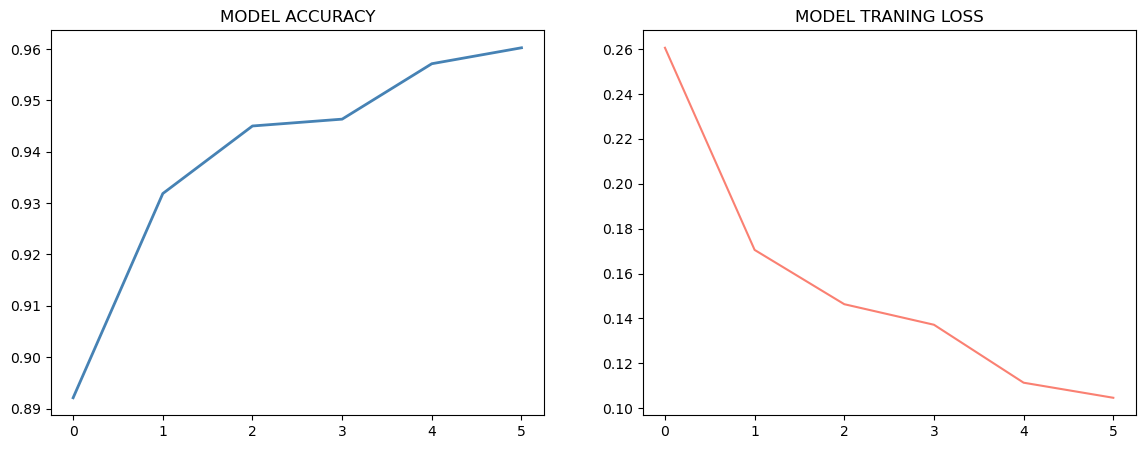

In [ ]:
#show model training accuracy and loss
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].set_title('MODEL ACCURACY')
ax[1].set_title('MODEL TRANING LOSS')
ax[0].plot(history.history['accuracy'], color= 'steelblue', lw=2);
ax[1].plot(history.history['loss'], color='salmon');

In [ ]:
#get the predictions for the test data using the trained model
predictions = np.argmax(model.predict(test_data),axis=1)

71/71 [==============================] - 53s 717ms/step


In [ ]:
#print a classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1188
           1       0.00      0.00      0.00      1068

    accuracy                           0.53      2256
   macro avg       0.26      0.50      0.34      2256
weighted avg       0.28      0.53      0.36      2256



In [ ]:
#Analysis of the Provided Report
#Class 0 (support: 1188)
#Precision: 0.53 — About 53% of the predicted "0" were actually correct.
#Recall: 1.00 — The model identified all actual "0" instances.
#F1-Score: 0.69 — Represents the balance between precision and recall.

#Class 1 (support: 1068)
#Precision, Recall, and F1-Score are all 0. This indicates that the model failed to identify any "1" instances correctly.
#Overall Accuracy: 0.53 — The proportion of correct predictions out of all predictions made by the model.
#Macro Average: The average of precision, recall, and F1-score, calculated independently for each class.
#Precision: 0.26, Recall: 0.50, F1-Score: 0.34
#Weighted Average: Averages the metrics, weighting each class's contribution by its support.
#Precision: 0.28, Recall: 0.53, F1-Score: 0.36

In [ ]:
for img, label in test_data.take(1):
    sample_img = img[1]
    img_true_label = label[1]


1/1 [==============================] - 2s 2s/step


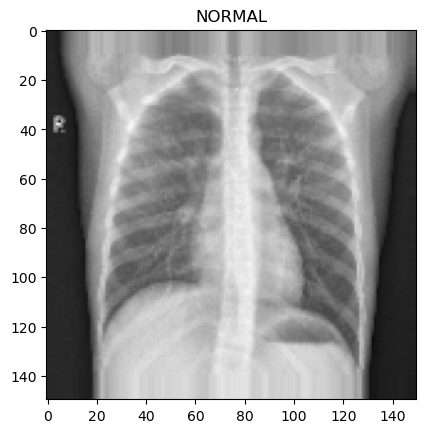

In [ ]:
pred = np.array(np.argmax(model.predict(tf.expand_dims(sample_img, 0))).flatten()[0])
plt.title(CATEGORIES[pred])
plt.imshow(sample_img);


In [ ]:
#show image true label
print('IMAGE TRUE LABEL: ', CATEGORIES[img_true_label])

IMAGE TRUE LABEL:  NORMAL


In [ ]:
#Conclusion
#This classification report suggests that the model heavily favors predicting class "0" over class "1".
#It has high recall for class "0" but fails to identify class "1", resulting in low precision, recall,
#and F1-score for class "1".
#This could indicate a class imbalance issue or a problem with the model's ability to distinguish between the classes.